<a href="https://colab.research.google.com/github/Girija05-m/Customer-Churn-Prediction-using-ML/blob/main/Customer_Churn_Prediction_using_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score
)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression



**Reading the dataset and Load Dataset**

In [ ]:
df = pd.read_csv("/content/Telco-Customer-Churn.csv")
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**Dataset Inspection**

In [ ]:
print(df.shape) #returns the tuple (no.of rows and column )
df.info()#give  the information
df.isna().sum()#Counts the number of missing (NaN) values in each column of a DataFrame


(7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


**Drop Unnecessary Column**

In [ ]:
df.drop('customerID', axis=1, inplace=True)


**Fix TotalCharges Column**

In [ ]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


/tmp/ipython-input-2576541415.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


**Target Variable Encoding (Churn)**

In [ ]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
df['Churn'].value_counts()


,count
Churn,
0,5174
1,1869


**Feature Engineering**

In [ ]:
# Average charge per month
df['AvgCharges'] = df['TotalCharges'] / (df['tenure'] + 1)

# Long term customer or not
df['Is_Long_Term'] = (df['tenure'] > 24).astype(int)


**Separate Features & Target**

In [ ]:
X = df.drop('Churn', axis=1)
y = df['Churn']


**Identify Categorical & Numerical Columns**

In [ ]:
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns


**Preprocessing Pipeline**

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ]
)


**Train-Test Split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


**SMOTE + Model Pipeline**

In [ ]:
logistic_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(max_iter=1000))
])

logistic_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
       'AvgCharges', 'Is_Long_Term'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('model', LogisticRegression(max_iter=1000))])

**Random Forest Pipeline**

In [ ]:
rf_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(
        n_estimators=200,
        max_depth=8,
        class_weight='balanced',
        random_state=42
    ))
])

rf_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
       'AvgCharges', 'Is_Long_Term'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=8,
                                        n_estimators=200, random_state=42))])

**Model Evaluation Function**

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))

    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True, fmt='d', cmap='Blues')
    plt.show()


**Evaluate Models**

Logistic Regression Performance
              precision    recall  f1-score   support

           0       0.91      0.74      0.81      1294
           1       0.52      0.79      0.63       467

    accuracy                           0.75      1761
   macro avg       0.71      0.76      0.72      1761
weighted avg       0.80      0.75      0.77      1761

Accuracy: 0.7524134014764339
ROC-AUC: 0.848146113341431


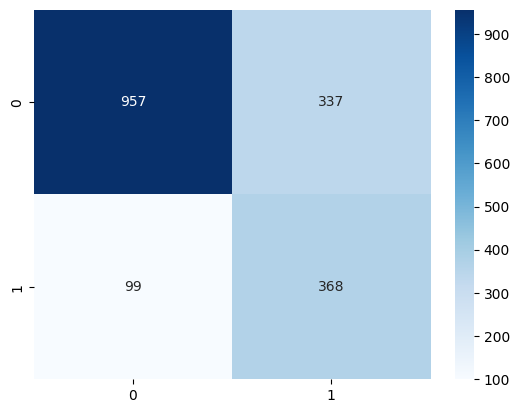

Random Forest Performance
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1294
           1       0.55      0.74      0.63       467

    accuracy                           0.77      1761
   macro avg       0.72      0.76      0.73      1761
weighted avg       0.80      0.77      0.78      1761

Accuracy: 0.7705848949460534
ROC-AUC: 0.8436863931371609


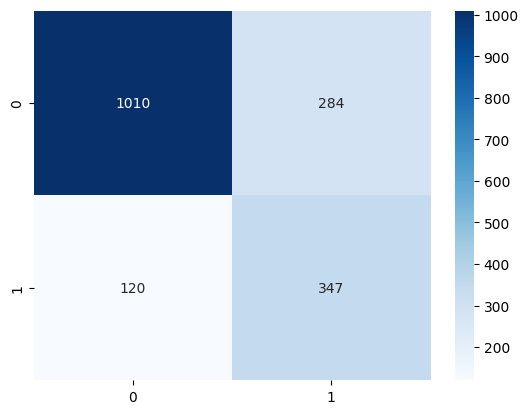

In [ ]:
print("Logistic Regression Performance")
evaluate_model(logistic_pipeline, X_test, y_test)

print("Random Forest Performance")
evaluate_model(rf_pipeline, X_test, y_test)


**Feature Importance**

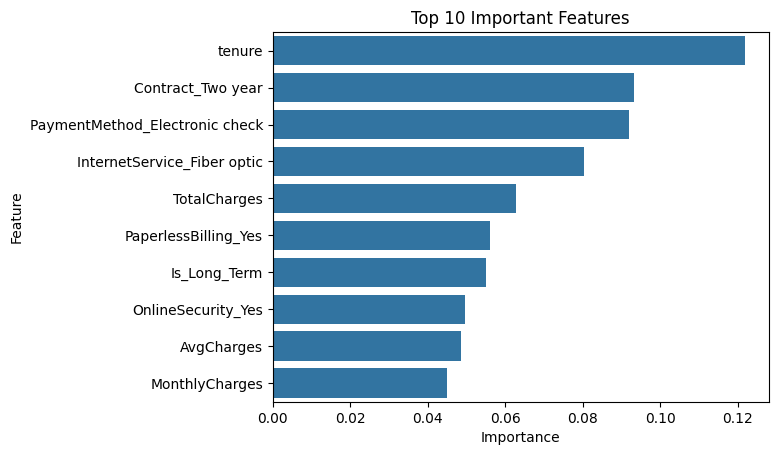

In [ ]:
feature_names = (
    rf_pipeline.named_steps['preprocess']
    .transformers_[0][2].tolist() +
    list(
        rf_pipeline.named_steps['preprocess']
        .transformers_[1][1]
        .get_feature_names_out(categorical_cols)
    )
)

importances = rf_pipeline.named_steps['model'].feature_importances_

feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(10)

sns.barplot(data=feature_df, x='Importance', y='Feature')
plt.title("Top 10 Important Features")
plt.show()


**To save the  model**

In [ ]:
import joblib

joblib.dump(logistic_pipeline, "logistic_churn_model.pkl")
joblib.dump(rf_pipeline, "rf_churn_model.pkl")

print("Models saved successfully!")




Models saved successfully!
